This is a demo of [`homogint`](https://github.com/olivierverdier/homogint), a simple Python library for integration on homogeneous spaces. The theoretical background is explained in the paper [Integrators on homogeneous spaces][paper], by [Oivier Verdier](https://www.olivierverdier.com/) and Hans Munthe-Kaas.

[paper]: http://arxiv.org/abs/1402.6981

## General imports

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from homogint import Integrator, time_step
import homogint.skeletons as sk

Plotting routine:

In [2]:
def plot_sphere(ax=None):
    if ax is None:
        ax = plt.gcf().add_subplot(111, projection='3d')
    ax.autoscale(tight=True)
    ax.set_axis_off()
    ax.set_aspect("equal")

    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100).reshape(-1,1)

    x = np.cos(u) * np.sin(v)
    y = np.sin(u) * np.sin(v)
    z = np.cos(v)
    ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='k', alpha=.1)

    return ax

## Set up the solver

We will use the fourth order Rungke–Kutta–Munthe-Kaas method.

It can be described by the following *transition functions* (see [§3 in the paper][paper]):

\\[
\begin{align}
    \theta\_{1,0} &= \frac{1}{2} F\_{0} \\\\
	\theta\_{2,0} &= \frac{1}{2}F\_1 - \frac{1}{8}[F\_{0},F\_1]\\\\
    \theta\_{3,0} &= F\_2 \\\\
    \theta\_{4,0} &= \frac{1}{6} (F\_0 + 2(F\_1+F\_2) + F\_3) - \frac{1}{12} [F\_0, F\_3]
\end{align}
\\]

[paper]: http://arxiv.org/abs/1402.6981

In [3]:
from homogint import Geodesic

We define a simple solver function that we use to solve the examples.

In [4]:
import tqdm

In [8]:
def solve(vf,xs,stopping,geodesic=Geodesic(), maxit=10000):
    """
    Simple solver with stopping condition. The list xs is modified **in place**.
    """
    rkmk4 = Integrator(sk.RKMK4(), geodesic)
    for i in tqdm.tqdm(range(maxit)):
        if stopping(i,xs[-1]):
            break
        xs.append(rkmk4.step(vf, xs[-1]))

## Sphere: quadrature

*Example from [DiffMan](https://github.com/kenthe/DiffMan/blob/master/auxiliary/examples/vfex5.m)*.

We study the solution of the equation $x'(t) = ξ(t)x(t)$, where $x$ is on the sphere, and
\\[
ξ(t) = \begin{bmatrix}0 & t & -0.4\cos(t) \\ -t & 0 & 0.1t \\ 0.4 \cos(t) & -0.1 t & 0\end{bmatrix} \in \mathsf{so}(3)
\\]

This is equivalent to consider the problem
\\[
x'(t) = ω(t) \times x(t)
\\]
with $ω(t) = -(0.1t,0.4\cos(t),t)$.

We use a bit of a trickery here, and use instead the autonomous vector (in block notation):
\\[
\zeta(x) = \begin{bmatrix} \xi(t) & 0 &0 \\ 0 & 0 & 1 \\ 0 & 0 & 0 \end{bmatrix}
\\]
This amounts to work with the group $\mathsf{SO(3) \times \mathbf{R}}$ instead.

In [9]:
def timedep_field(x):
    """
    Example from Diffman manual.
    """
    J = np.zeros([5,5])
    t = x[-2]
    J[0,1] = t
    J[0,2] = -.4*np.cos(t)
    J[1,2] = .1*t
    J -= J.T
    J[-2,-1] = 1.
    return J

In [10]:
xs = [np.array([0.,0,1,0,1])]
dt = .02
solve(time_step(dt)(timedep_field),xs,lambda i,x:x[-2]>10)
axs = np.array(xs)

  5%|█▊                                 | 501/10000 [00:02<00:44, 213.51it/s]


In [11]:
def plot2(axs):
    plt.plot(axs[0,0],axs[0,1],'o')
    plt.plot(axs[:,0], axs[:,1],marker='.')

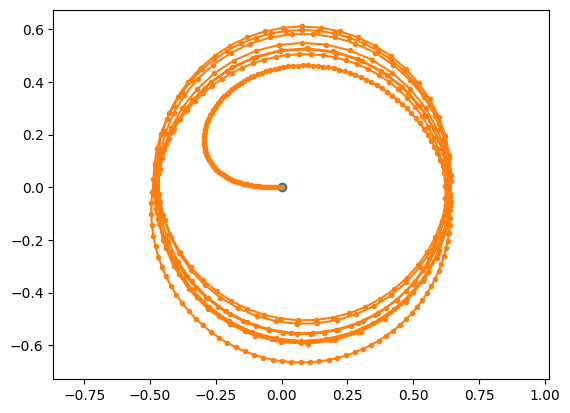

In [12]:
plt.axis('equal')
plot2(axs)

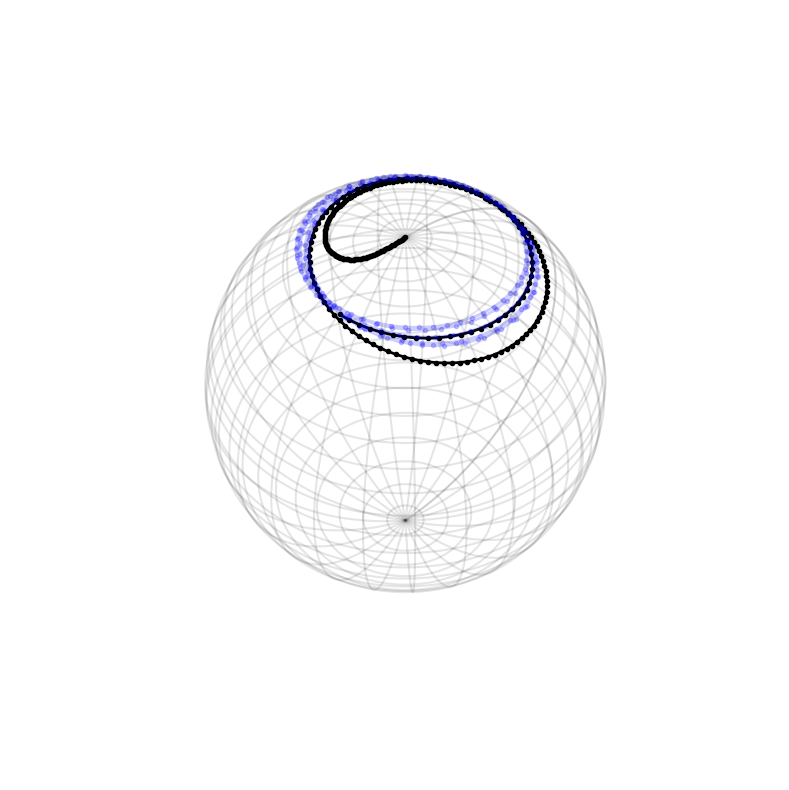

In [13]:
fig = plt.figure(figsize=(15,10))
ax = plot_sphere()
tot = len(xs)
for i,s in enumerate([slice(0,tot//2,None), slice(tot//2,None,None)]):
    ax.plot(axs[s,0],axs[s,1],axs[s,2],lw=2,marker='.',color=['black','blue'][i], alpha=[1.,0.2][i])
ax.view_init(50,-130)
# savefig('quad.pdf')

## $\mathsf{SO}(3)$: Quadrature

*Example from [DiffMan](https://github.com/kenthe/DiffMan/blob/master/auxiliary/examples/vfex1.m)*

The field is
\\[
\xi(t) = \begin{bmatrix} 0 & t & 1\\ -t & 0 & -t^2 \\ -1 & t^2 & 0\end{bmatrix}
\\]

In [14]:
def so31_field(x):
    t = x[3,3]
    xi = np.zeros([5,5])
    xi[0,1] = t
    xi[0,2] = 1.
    xi[1,2] = -t*t
    xi -= xi.T
    xi[-2,-1] = 1.
    return xi

In [15]:
x0 = np.zeros([5,4])
x0[:3,:3] = np.identity(3)
x0[-1,-1] = 1.
xs = [x0]
dt = .01
solve(time_step(dt)(so31_field), xs, lambda i,x: x[-2,-1] > 5)

  5%|█▊                                 | 501/10000 [00:03<00:58, 163.06it/s]


In [16]:
axs = np.array(xs)

Plot the three unit vectors of the rotation matrix:

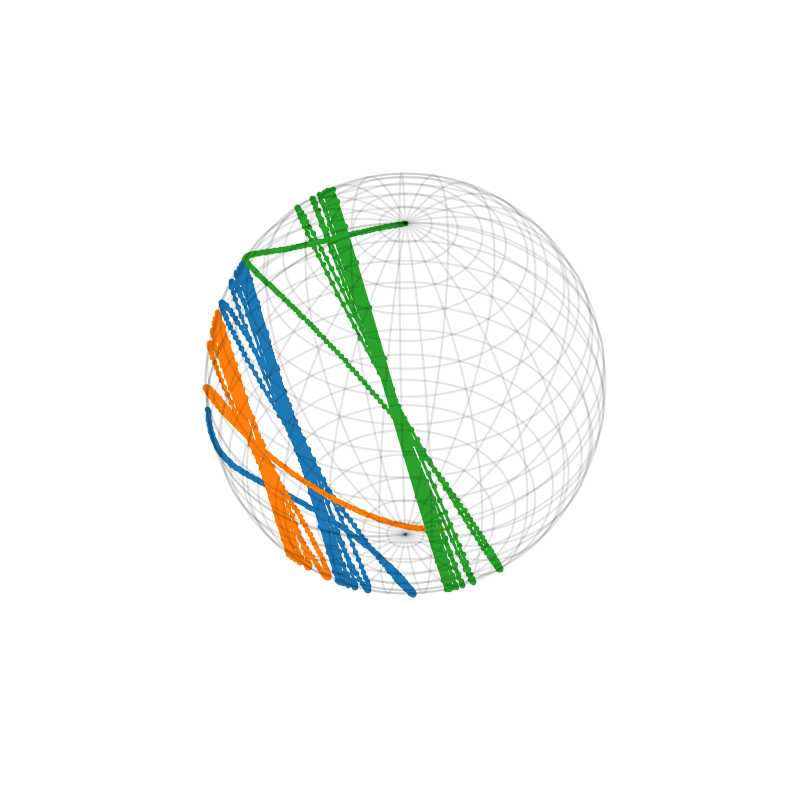

In [17]:
fig = plt.figure(figsize=(15,10))
ax = plot_sphere()
for i in range(3):
    ax.plot(axs[:,0,i],axs[:,1,i],axs[:,2,i],lw=2,marker='.')
ax.view_init(45,80)
plt.savefig('so3quad.svg', bbox_inches='tight', pad_inches=-1.5)

## Flat space: Lorenz equation

*Example from [DiffMan](https://github.com/kenthe/DiffMan/blob/master/auxiliary/examples/vfex2.m)*

This is the equation
\\[
(x,y,z)' = (-βx + yz, -σy + σz, -xy + ρy - z)
\\]
with the values
\\[
σ = 10 \qquad ρ = 28 \qquad β = 8/3
\\]

The idea here is to use the translation group, so the infinitesimal vector field is
\\[
\xi(x) = \begin{bmatrix} 0 & v(x)\\ 0 & 0\end{bmatrix}
\\]
where $v(x)\in\mathbf{R}^3$ is the Lorenz vector field above.

In [18]:
def lorenz(x, sigma=10, beta=8./3., rho=28):
    y = x[1]
    A = np.array([[-beta, 0, y],
         [0, -sigma, sigma],
        [-y, rho, -1]])
    vf = np.dot(A,x[:3])
    xi = np.zeros([4,4])
    xi[:-1,-1] = vf # translation only
    return xi

In [19]:
xs = [np.array([25.,0,-20,1])]
solve(time_step(0.02)(lorenz), xs, lambda i,x: i > 20/.02)

 10%|███▍                              | 1001/10000 [00:05<00:47, 188.25it/s]


In [20]:
axs = np.array(xs)

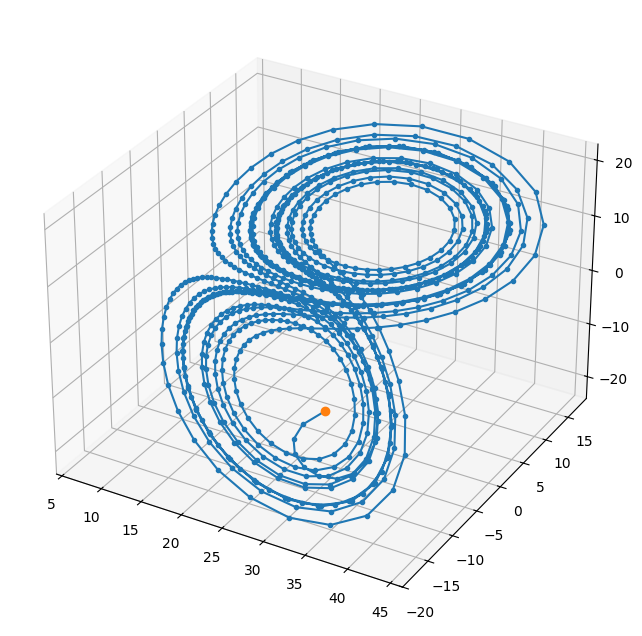

In [21]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(axs[:,0],axs[:,1],axs[:,2],marker='.')
ax.plot([axs[0,0]],[axs[0,1]],[axs[0,2]],marker='o')
#ax.view_init(90,120)

## Isospectral Manifold: Toda flow

An isospectral flow is an equation of the form
\\[
P' = ξ(P)P - Pξ(P)
\\]
where $P$ is symmetric and $ξ(P)$ is skew-symmetric.

We implement what is known as the *Toda flow*:

In [22]:
def iso_field(P):
    sk = np.tril(P) - np.triu(P) # skew symmetric
    return sk

Random symmetric matrix as initial condition.

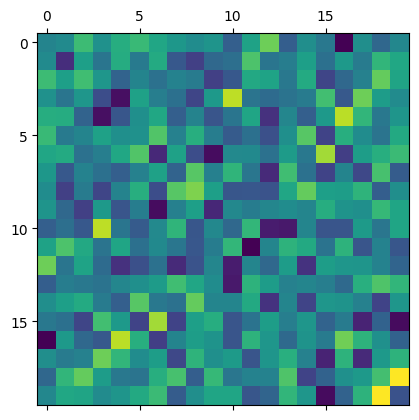

In [23]:
#init = np.array([[-1.,1,0],[1,.5,1],[0,1,.5]])
rmat = np.random.randn(20,20)
init = rmat + rmat.T
plt.matshow(init)
plt.savefig('matinit.png', bbox_inches='tight', pad_inches=0)

In [26]:
from homogint.actions import trans_adjoint
Ps = [init]
dt = .25
solve(time_step(dt)(iso_field), Ps, lambda i,x: i>30/dt, geodesic=Geodesic(trans_adjoint))

  1%|▍                                   | 121/10000 [00:37<51:37,  3.19it/s]


The flow does not change the eigenvalues (hence the name *isospectral flow*)

Text(0.5, 1.0, 'eigenvalue drift')

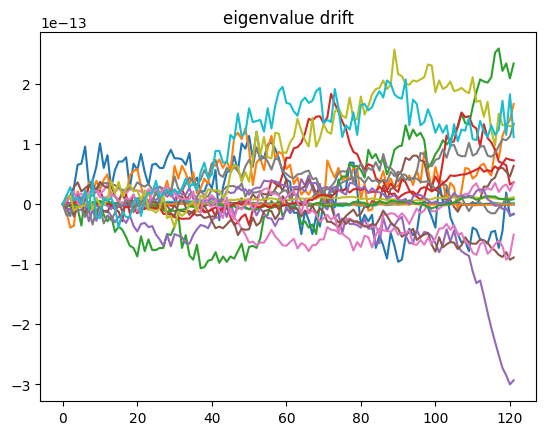

In [27]:
import numpy.linalg as nl
eigenvalues = [np.sort(nl.eigvals(P)) for P in Ps]
aeigenvalues = np.array(eigenvalues)
deig = aeigenvalues - aeigenvalues[0]
plt.plot(deig)
plt.title("eigenvalue drift")

In [28]:
from ipywidgets import interact
def view_matrix(i):
    plt.matshow(Ps[i])
interact(view_matrix, i=(0,len(Ps)-1,1))

interactive(children=(IntSlider(value=60, description='i', max=121), Output()), _dom_classes=('widget-interact…

<function __main__.view_matrix(i)>

The flow is a continuous version of the [QR algorithm](http://www.wikiwand.com/en/QR_algorithm), so it almost converges towards a diagonal matrix (*almost* because there is no shift and deflations).

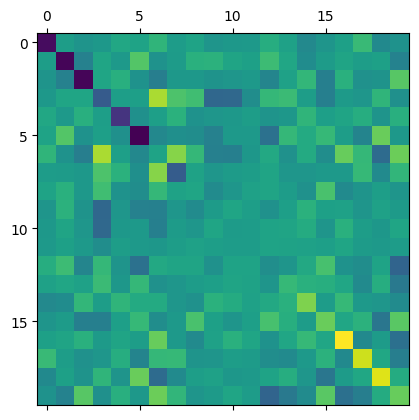

In [29]:
plt.matshow(Ps[-1])
plt.savefig('matfinal.png', bbox_inches='tight', pad_inches=0)

## Airy Equation

*Example from [Lie Group Method](http://www.damtp.cam.ac.uk/user/na/NA_papers/NA2000_03.pdf)*

We solve the equation
\\[
x'' + tx = 0
\\]

It is reformulated as
\\[
(x,v)' = \begin{bmatrix} 0 & 1\\ -t & 0\end{bmatrix} (x,v)
\\]

In [30]:
def airy_field(x):
    mat = np.zeros([4,4])
    mat[0,1] = 1.
    mat[1,0] = -x[-2]
    mat[-2,-1] = 1 # time
    return mat

We solve it with initial condition $x(0) = 1.$, $x'(0) = 0$.

In [31]:
%%time
x0 = np.array([1.,0,0,1])
xs = [x0]
dt=.05
solve(time_step(dt)(airy_field), xs, stopping=lambda i,x: i>100/dt)

 20%|██████▊                           | 2001/10000 [00:09<00:38, 209.14it/s]

CPU times: user 27.9 s, sys: 1.13 s, total: 29.1 s
Wall time: 9.57 s


In [32]:
len(xs)

2002

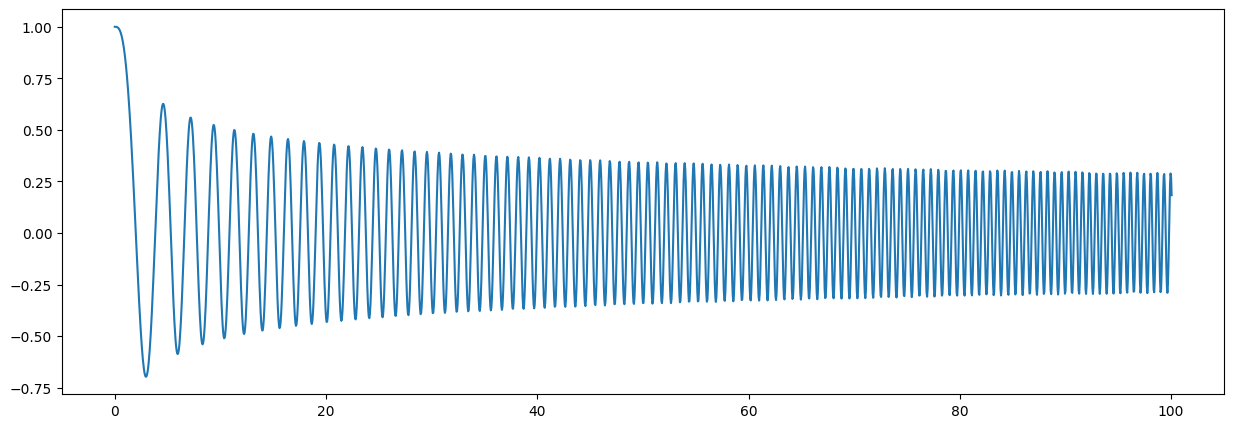

In [33]:
fig = plt.figure(figsize=(15,5))
axs = np.array(xs)
plt.plot(axs[:,-2],axs[:,0])
#plot(axs[1900:,-2],axs[1900:,0],marker='.')

We can compute the exact solution using the `airy` function in `scipy.special`.

In [34]:
from scipy.special import airy
from scipy.linalg import solve as linsolve

In [35]:
# taken from the DiffMan examples
tstart = 0
m =np.array([airy(tstart)[0], airy(tstart)[2], -airy(tstart)[1], -airy(tstart)[3]]).reshape(2,-1)
c = linsolve(m, np.array([1.,0]))

# Computes the 'true' solution:
ts = np.linspace(90,100,1000)
def exact_airy(ts, c):
    return c[0]*np.real(airy(-ts)[0]) + c[1]*np.real(airy(-ts)[2])

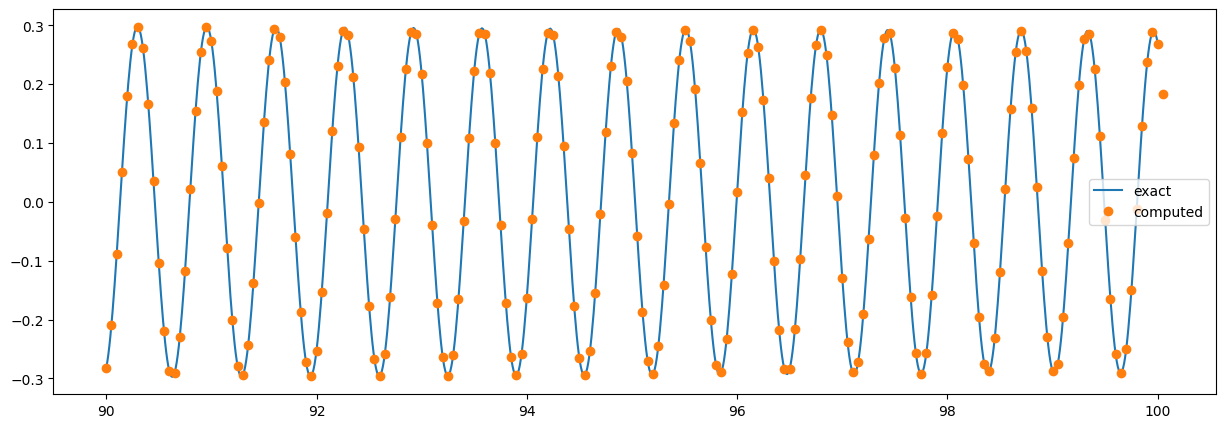

In [36]:
plt.figure(figsize=(15,5))
skip=1800
plt.plot(ts,exact_airy(ts,c),label="exact")
plt.plot(axs[skip:,-2],axs[skip:,0],marker='o',linestyle='',label="computed")
plt.legend()

Text(0.5, 1.0, '$\\log_{10}(error)$')

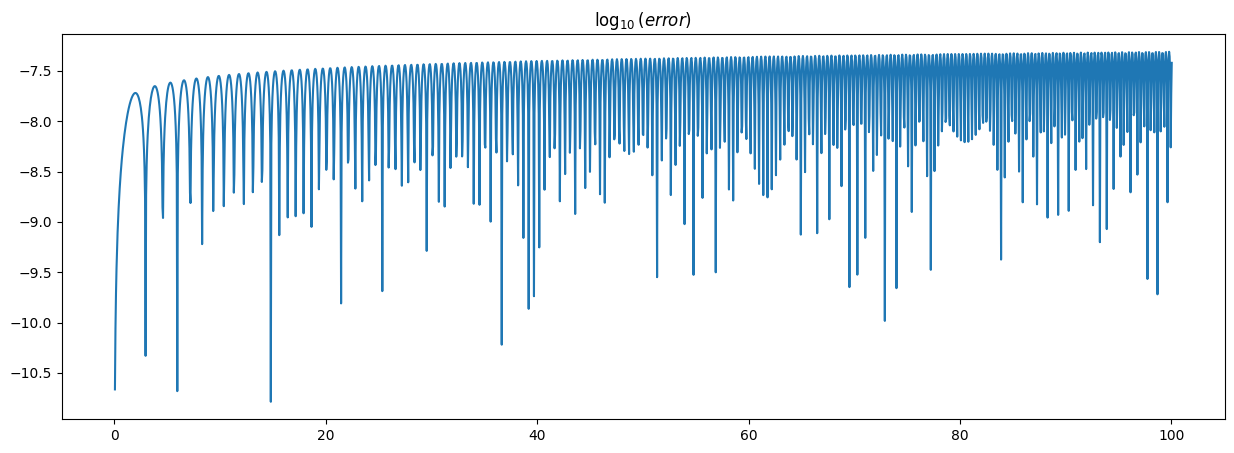

In [37]:
plt.figure(figsize=(15,5))
error = axs[:,0] - exact_airy(axs[:,-2],c)
plt.plot(axs[1:,-2],np.log10(np.abs(error[1:])))
plt.title(r"$\log_{10}(error)$")

## Stiefel manifold: Oja Flow

*Example from [Geometric Numerical Integration, § IV.9.2](http://link.springer.com/book/10.1007%2F3-540-30666-8)*

The *Oja flow* is given by
\\[
Q' = (I - QQ^T)A Q
\\]
for a given positive definite matrix $A$.

Using the connection formula 
\\[
\langle ω,δQ \rangle_Q = δQ Q^T - QδQ^T -QδQ^T Q Q^T
\\]
we obtain the following vector field on the Lie algebra:
\\[
ξ(Q) = AQQ^T-QQ^TA
\\]

In [38]:
D = np.diag([16.,8.,4.])
A = D
def oja_field(x):
    proj = np.dot(x,x.T)
    xi = sk.commutator(A,proj)
    return xi

We choose a random starting point. It amounts to choose two orthogonal vectors of length one.

In [39]:
def normalize(x):
    nx = np.sqrt(np.sum(np.square(x)))
    return x/nx

def rand_sphere_point():
    u,v = np.random.rand(2)
    phi = u*2*np.pi
    theta = np.arccos(2*v-1)
    sth = np.sin(theta)
    return np.array([sth*np.cos(phi), sth*np.sin(phi), np.cos(theta)])
r1 = rand_sphere_point()
r1_ = rand_sphere_point()
r2 = normalize(np.cross(r1,r1_))
x0 = np.array([r1,r2]).T

Check that the chosen vectors are orthogonal:

In [40]:
print(np.allclose(np.dot(x0.T,x0), np.identity(2)))

True


Starging value:

In [41]:
print(x0)

[[ 0.72806577 -0.63203521]
 [-0.09262233  0.29294874]
 [ 0.67922112  0.71743469]]


In [42]:
xs = [x0]
dt = .1
solve(time_step(dt)(oja_field), xs, lambda i,x: np.allclose(oja_field(x),0,atol=1e-7))

  0%|▏                                   | 49/10000 [00:00<01:01, 162.39it/s]


In [43]:
len(xs)

50

The flow converges towards an invariant subspace. Here it converges towards the subspace containing the two largest eigenvalues:

In [44]:
xs[-1]

array([[ 7.75827951e-01, -6.30944523e-01],
       [ 6.30944523e-01,  7.75827951e-01],
       [ 1.19947786e-08,  1.47491328e-08]])

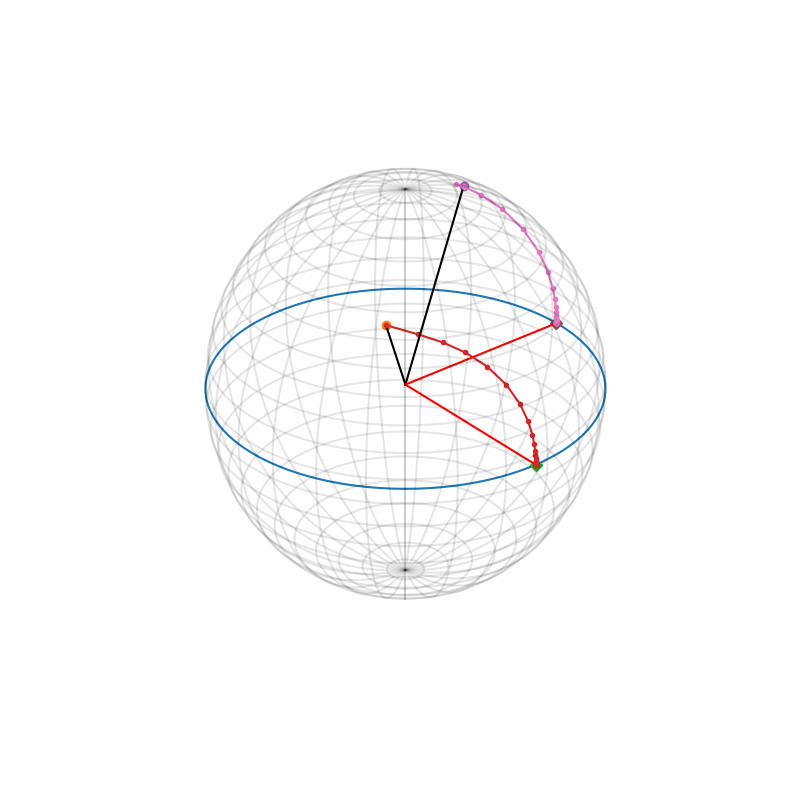

In [45]:
axs = np.array(xs)
fig = plt.figure(figsize=(15,10))
ax = plot_sphere()
ths = np.linspace(0,2*np.pi,200)
plt.plot(np.cos(ths), np.sin(ths), np.zeros_like(ths))
for i in range(2):
    for j in [0,-1]:
        ax.plot([axs[j,0,i]],[axs[j,1,i]],[axs[j,2,i]],lw=2,marker=['o','D'][j])
        ax.plot([0.,axs[j,0,i]],[0,axs[j,1,i]],[0,axs[j,2,i]],color=['black','red'][j])
    ax.plot(axs[:,0,i],axs[:,1,i],axs[:,2,i],marker='.')
ax.view_init(30,0)
plt.savefig('oja.pdf')

Check the convergence towards the plane with largest eigenvalues.

Text(0.5, 1.0, 'log10 of the z coordinate')

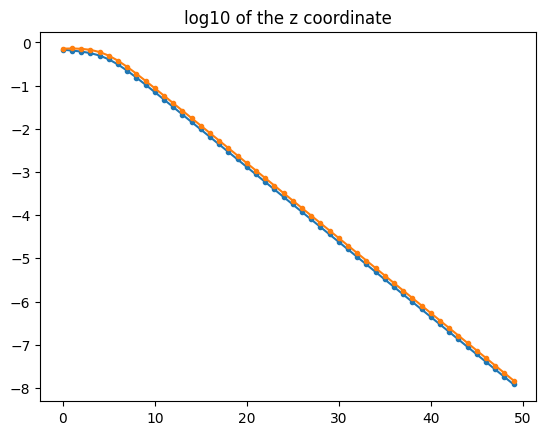

In [46]:
for i in range(2):
    plt.plot(np.log10(np.abs(axs[:,-1,i])),marker='.')
plt.title("log10 of the z coordinate")